### import Package


In [17]:
import numpy as np
import pandas as pd
import os 
from statsmodels.regression.rolling import RollingOLS
from scipy.stats import ttest_1samp
import statsmodels.api as sm
import matplotlib.pyplot as plt

### Function

In [18]:
def ret_calculate(df, start, end, price_col, tickers_col) :
    df = df.copy().sort_index() 
    df[f'ret{start}_{end}'] = df.groupby(tickers_col)[price_col].transform(lambda x : (x.shift(end)/x.shift(start))-1).round(6)
    return df

def ttest(variable,df) :
    loser = df[df[variable] == 1][['time', 'total_pret','sprtrn', 'Mkt-RF', 'HML', 'SMB']].reset_index(drop= True).set_index('time').rename(columns={'total_pret' : 'loser'})
    winner = df[df[variable] == 5][['time', 'total_pret']].reset_index(drop= True).set_index('time').rename(columns={'total_pret' : 'winner'})
    long_short = pd.merge(loser,winner,left_index=True, right_index=True)
    if variable == 'momentum_group' :
        long_short['WML'] = long_short['winner'] - long_short['loser']
    if variable == 'reversal_group' :
        long_short['WML'] = long_short['loser'] - long_short['winner']
    # 假設檢定的母體平均值為 2.5
    population_mean = 0

    # 進行單一樣本 t 檢定
    mean = long_short['WML'].mean().round(3)
    t_stat, p_value = ttest_1samp(long_short['WML'], population_mean)
    Y = long_short['WML']
    X = sm.add_constant(long_short[['Mkt-RF', 'HML', 'SMB']].astype('float'))  # 自變數矩陣，包含常數項

    # 執行回歸分析
    model = sm.OLS(Y, X).fit()

    # 提取截距項 (alpha)
    alpha = model.params[0].round(3)
    alpha_pvalue = model.pvalues[0].round(4)  # 截距項的 P 值

    # 輸出結果
    if p_value > 0.1 :
        print(f"W-L: {mean}")
    elif (p_value < 0.1) & (p_value > 0.05) :
        print(f"W-L: {mean}*")
    elif (p_value < 0.05) & (p_value > 0.01) :
        print(f"W-L: {mean}**")    
    elif p_value < 0.01 :
        print(f"W-L: {mean}***")
    print(f"p values of maen: {p_value.round(4)}")
    # 輸出結果
    if alpha_pvalue > 0.1 :
        print(f"alpha: {alpha}")
    elif (alpha_pvalue < 0.1) & (alpha_pvalue > 0.05) :
        print(f"alpha: {alpha}*")
    elif (alpha_pvalue < 0.05) & (alpha_pvalue > 0.01) :
        print(f"alpha: {alpha}**")    
    elif alpha_pvalue < 0.01 :
        print(f"alpha: {alpha}***")
        
    print(f"p values of alpha: {alpha_pvalue}")

def replace_outliers(group,value):
    lower_bound = group[value].quantile(0.01)  # 1 分位數
    upper_bound = group[value].quantile(0.99)  # 99 分位數
    
    # 替換小於下界的值為下界
    group[value] = group[value].apply(lambda x: lower_bound if x < lower_bound else x)
    
    # 替換大於上界的值為上界
    group[value] = group[value].apply(lambda x: upper_bound if x > upper_bound else x)
    
    return group


def histogram_plot(df, WML, alpha ) :
    x = np.arange(len(df.index))  # [0, 1, 2, 3, 4]
    width = 0.35

    # 繪製柱狀圖
    fig, ax = plt.subplots(figsize=(8, 6))
    rects1 = ax.bar(x - width/2, df[WML], width, label=WML, color='white', edgecolor='black')
    rects2 = ax.bar(x + width/2, df[alpha], width, label=alpha, color='black')

    # 添加標籤和標題
    ax.set_xlabel('Idiosyncratic Risk Quintile')
    ax.set_ylabel('Monthly Returns')
    ax.set_title('Monthly Returns by Idiosyncratic Risk Quintile')
    ax.set_xticks(x)
    ax.set_xticklabels(df.index)
    ax.legend()

    # 顯示圖形
    plt.tight_layout()
    plt.show()

### import data

In [19]:
path = r"C:\Users\USER\Desktop\Replication\data"
MOM_path = os.path.join(path, r'F-F_Momentum_Factor.csv')
FF5_path = os.path.join(path, r'F-F_Research_Data_Factors.csv')
crsp_path = os.path.join(path, r'qwq86kkdqyampw3g.csv')
main_variables =['mkt_value', 'idio_risk', 'future_idio_risk', 'variance']
crsp = pd.read_csv(crsp_path,index_col='date', parse_dates= True)
FF5 = pd.read_csv(FF5_path,header=3)
mom = pd.read_csv(MOM_path, header = 13)
FF_factor = pd.merge(FF5, mom, on = 'date', how= 'left')
crsp


C:\Users\USER\AppData\Local\Temp\ipykernel_18604\4132249188.py:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  crsp = pd.read_csv(crsp_path,index_col='date', parse_dates= True)


,PERMNO,SICCD,TICKER,COMNAM,PERMCO,CUSIP,PRC,RET,SHROUT,sprtrn
date,,,,,,,,,,
1985-12-31,10000,NaN,NaN,NaN,7952,68391610,NaN,NaN,NaN,0.045061
1986-01-31,10000,3990,OMFGA,OPTIMUM MANUFACTURING INC,7952,68391610,-4.37500,C,3680.0,0.002367
1986-02-28,10000,3990,OMFGA,OPTIMUM MANUFACTURING INC,7952,68391610,-3.25000,-0.257143,3680.0,0.071489
1986-03-31,10000,3990,OMFGA,OPTIMUM MANUFACTURING INC,7952,68391610,-4.43750,0.365385,3680.0,0.052794
1986-04-30,10000,3990,OMFGA,OPTIMUM MANUFACTURING INC,7952,68391610,-4.00000,-0.098592,3793.0,-0.014148
...,...,...,...,...,...,...,...,...,...,...
1985-08-30,93324,4310.0,ZCOM,ZYCOM INC,7304,98984810,-0.09375,-0.142857,14715.0,-0.011995
1985-09-30,93324,4310.0,ZCOM,ZYCOM INC,7304,98984810,-0.07813,-0.166667,14715.0,-0.034724
1985-10-31,93324,4310.0,ZCOM,ZYCOM INC,7304,98984810,-0.10938,0.400000,14715.0,0.042509


### Data Clean

In [20]:
crsp = crsp[(crsp['RET'] != 'C') & (crsp['RET'] != 'B')]
crsp = crsp[(crsp['SHROUT'] > 0) & (crsp['PRC'] > 0)]
crsp['RET'] = crsp['RET'].astype('float')
crsp['PRC_day1'] = crsp.groupby('CUSIP')['PRC'].transform('first')
crsp['Cumulative_RET'] = crsp.groupby('CUSIP')['RET'].transform(lambda x: (1 + x.iloc[1:]).cumprod() - 1)
crsp['Cumulative_RET'] = crsp['Cumulative_RET'].fillna(0)
crsp['Calculated_PRC'] = crsp['PRC_day1']*(1+crsp['Cumulative_RET'])
crsp['PRC'] = crsp['Calculated_PRC']
crsp = crsp.drop(columns=['PRC_day1','Cumulative_RET','Calculated_PRC'])
for t in range(1,6) :
    crsp[f'RET{t}'] = crsp.groupby('CUSIP')['PRC'].transform(lambda x : (x.shift(-t)/x.shift(1))-1).round(6)

#crsp.dropna()
crsp = crsp.groupby('CUSIP').filter(lambda x: len(x) > 36)
#crsp = crsp[crsp['PRC'] > 0]
crsp_1 = ret_calculate(crsp, 36, 7, 'PRC', 'CUSIP')#投組變數為t-36 ~ t-7，36會改成35跟7會改成6是因為此處的計算都是基於t-1期去計算t期的投組變數，之後分組時會取lag。因此t期時的t-36、t-7 = t-1期的t-35跟t-6(這好像是錯的)
crsp_2 = ret_calculate(crsp_1, 6, 1, 'PRC', 'CUSIP')
#crsp_2['RET'] = crsp_2.groupby('CUSIP')['PRC'].transform(lambda x : (x.shift(0)/x.shift(1))-1).round(6)
crsp_2['mkt_value'] = np.log(crsp_2['PRC']*crsp_2['SHROUT']*0.001)#論文沒說單位是多少，但*.001敘述統計的值才比較接近

In [21]:
crsp_2['time'] = pd.to_datetime(crsp_2.index)
codition = crsp_2['time'].dt.month < 10
crsp_2.loc[codition,'key'] = crsp_2.loc[codition,'time'].dt.year.astype('str') +'0' + crsp_2.loc[codition,'time'].dt.month.astype('str') 
crsp_2.loc[~codition,'key']  = crsp_2.loc[~codition,'time'].dt.year.astype('str') + crsp_2.loc[~codition,'time'].dt.month.astype('str') 
merge_df = pd.merge(crsp_2, FF_factor, how = 'left', right_on = 'date', left_on='key')
merge_df

,PERMNO,SICCD,TICKER,COMNAM,PERMCO,CUSIP,PRC,RET,SHROUT,sprtrn,...,mkt_value,time,key,date,Mkt-RF,SMB,HML,RF,Mom,Unnamed: 2
0,17347,2272,HAT,HAT CORP AMER,22770,57335010,8.750000,0.264286,897.0,0.033156,...,2.060354,1965-01-29,196501,196501,3.54,2.7,0.12,0.28,-1.44,NaN
1,11949,5411,FST,FIRST NATIONAL STORES INC,22317,33576510,51.000000,0.085106,1638.0,0.033156,...,4.425302,1965-01-29,196501,196501,3.54,2.7,0.12,0.28,-1.44,NaN
2,12220,4011,GFO,GULF MOBILE & OHIO RR CO,22339,40237010,50.250000,-0.031325,917.0,0.033156,...,3.830363,1965-01-29,196501,196501,3.54,2.7,0.12,0.28,-1.44,NaN
3,15667,2834.0,HPT,AMERICAN HOME PRODUCTS CORP,20086,98302410,72.000000,0.099124,23199.0,0.033156,...,7.420775,1965-01-29,196501,196501,3.54,2.7,0.12,0.28,-1.44,NaN
4,24635,3334,KLU,KAISER ALUMINUM & CHEMICAL CORP,23285,48310210,30.000000,0.004184,15575.0,0.033156,...,6.146864,1965-01-29,196501,196501,3.54,2.7,0.12,0.28,-1.44,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1953170,24459,3579,PBI,PITNEY BOWES INC,21411,72447910,5047.269758,0.057345,230620.0,0.032458,...,13.967374,2004-12-31,200412,200412,3.43,-0.03,-0.22,0.16,-2.87,NaN
1953171,87425,7375,TRRA,TERRA NETWORKS S A,17392,88100W10,6.390539,0.018745,13164.0,0.032458,...,4.432304,2004-12-31,200412,200412,3.43,-0.03,-0.22,0.16,-2.87,NaN
1953172,18286,3499,RAY,RAYTECH CORP DE,21491,75510310,9.365503,-0.005405,41737.0,0.032458,...,5.968421,2004-12-31,200412,200412,3.43,-0.03,-0.22,0.16,-2.87,NaN
1953173,83974,6020,GBBK,GREATER BAY BANCORP,14946,39164810,118.097160,-0.035370,51179.0,0.032458,...,8.706837,2004-12-31,200412,200412,3.43,-0.03,-0.22,0.16,-2.87,NaN


In [22]:

raw_df = merge_df.drop(columns=['key', 'date' ,'Unnamed: 2']).set_index(['time','CUSIP'], drop= False).sort_index()
raw_df.drop_duplicates(['time','PERMNO'],inplace=True)
#raw_df = raw_df[(raw_df['RET'] != 'C') & (raw_df['RET'] != 'B')]
raw_df['RET'] = raw_df['RET'].astype('float')
raw_df['EX_RET'] = raw_df['RET'] - raw_df['RF'].astype('float')
raw_df['intercept'] = 1
#raw_df.dropna(inplace=True)
raw_df = raw_df.groupby(level=1).filter(lambda x: len(x) > 36)
raw_df['variance'] = raw_df.groupby(level=1)['RET'].rolling(36).var().reset_index(0,drop=True)#記住，用groupby+rolling的方式創造新的欄位要確保groupby出來的series的index跟原本dataframe的index對的上，不然groupby順序會亂掉
raw_df['shift36_RET'] = raw_df.groupby(level =1)['RET'].shift(-35)
raw_df['shift36_sprtrn'] = raw_df.groupby(level =1)['sprtrn'].shift(-35)
raw_df.rename_axis(index={'time': 'date'},inplace= True)
raw_df

PERMNO   SICCD TICKER                         COMNAM  \
date       CUSIP                                                            
1965-01-29 00080010   10006    3743    ACF           A C F INDUSTRIES INC   
           00147610   10014    3714     AJ             A J INDUSTRIES INC   
           00168810   15763  3559.0    AMF        AMERICAN MACH & FDRY CO   
           00172320   18980    3579    AIN  ADDRESSOGRAPH MULTIGRAPH CORP   
           00173210   37591    2649    AMK         AMERICAN SEAL KAP CORP   
...                     ...     ...    ...                            ...   
2004-12-31 Y2693R10   89018  4412.0    GMR          GENERAL MARITIME CORP   
           Y2711Y11   87608    7370   GIGM                  GIGAMEDIA LTD   
           Y6476W10   86145  4412.0    OMM                 O M I CORP NEW   
           Y6618310   86731  7370.0  PCNTF           PACIFIC INTERNET LTD   
           Y8564W10   81784  4412.0     TK           TEEKAY SHIPPING CORP   

                     PERMCO     CUSIP         PRC       RET   SHROUT  \
date       CUSIP                                                       
1965-01-29 00080010   22156  00080010   83.750000  0.053459   2968.0   
           00147610   22157  00147610    2.625000  0.050000   3369.0   
           00168810   22631  00168810   18.375000  0.006849  17157.0   
           00172320   20009  00172320   51.750000  0.112903   7992.0   
           00173210   21816  00173210   12.250000 -0.020000    989.0   
...                     ...       ...         ...       ...      ...   
2004-12-31 Y2693R10   41695  Y2693R10   39.950002 -0.121012  37693.0   
           Y2711Y11   18009  Y2711Y11    6.334998 -0.108374  50154.0   
           Y6476W10   34809  Y6476W10   17.118606 -0.208236  85630.0   
           Y6618310   16399  Y6618310    7.059996 -0.142163  13294.0   
           Y8564W10   30928  Y8564W10  115.286146 -0.209350  83502.0   

                       sprtrn  ...  Mkt-RF    SMB    HML    RF  Mom     \
date       CUSIP               ...                                       
1965-01-29 00080010  0.033156  ...    3.54    2.7   0.12  0.28   -1.44   
           00147610  0.033156  ...    3.54    2.7   0.12  0.28   -1.44   
           00168810  0.033156  ...    3.54    2.7   0.12  0.28   -1.44   
           00172320  0.033156  ...    3.54    2.7   0.12  0.28   -1.44   
           00173210  0.033156  ...    3.54    2.7   0.12  0.28   -1.44   
...                       ...  ...     ...    ...    ...   ...     ...   
2004-12-31 Y2693R10  0.032458  ...    3.43  -0.03  -0.22  0.16   -2.87   
           Y2711Y11  0.032458  ...    3.43  -0.03  -0.22  0.16   -2.87   
           Y6476W10  0.032458  ...    3.43  -0.03  -0.22  0.16   -2.87   
           Y6618310  0.032458  ...    3.43  -0.03  -0.22  0.16   -2.87   
           Y8564W10  0.032458  ...    3.43  -0.03  -0.22  0.16   -2.87   

                       EX_RET  intercept  variance shift36_RET shift36_sprtrn  
date       CUSIP                                                               
1965-01-29 00080010 -0.226541          1       NaN    0.002793       0.026277  
           00147610 -0.230000          1       NaN    0.311475       0.026277  
           00168810 -0.273151          1       NaN    0.050314       0.026277  
           00172320 -0.167097          1       NaN    0.156648       0.026277  
           00173210 -0.300000          1       NaN    0.112179      -0.043848  
...                       ...        ...       ...         ...            ...  
2004-12-31 Y2693R10 -0.281012          1  0.020468         NaN            NaN  
           Y2711Y11 -0.268374          1  0.061306         NaN            NaN  
           Y6476W10 -0.368236          1  0.013736         NaN            NaN  
           Y6618310 -0.302163          1  0.086733         NaN            NaN  
           Y8564W10 -0.369350          1  0.009035         NaN            NaN  

[1953175 rows x 29 columns]

In [23]:
#以未來36個月的月超額報酬與市場超額報酬回歸所得到的未來殘差標準差(future_Ivol)
gb = raw_df.groupby(level=1)
reg1 = gb.apply(lambda g: RollingOLS(g['shift36_RET'], g[['intercept', 'shift36_sprtrn']], window=36,min_nobs= 36, missing='drop').fit().mse_resid).reset_index(0,drop=True)#取出單一個result(如mse)、t_value，就不能用data1.groupby('id')[['ret', 'intercept', 'MKT_ret']]
raw_df_1 = pd.concat([raw_df, reg1], axis = 1)  
raw_df_1.rename(columns= {raw_df_1.columns[-1] : 'future_idio_risk'}, inplace=True)
#raw_df_1.set_index('date', inplace= True)
raw_df_1

PERMNO   SICCD TICKER                         COMNAM  \
date       CUSIP                                                            
1965-01-29 00080010   10006    3743    ACF           A C F INDUSTRIES INC   
           00147610   10014    3714     AJ             A J INDUSTRIES INC   
           00168810   15763  3559.0    AMF        AMERICAN MACH & FDRY CO   
           00172320   18980    3579    AIN  ADDRESSOGRAPH MULTIGRAPH CORP   
           00173210   37591    2649    AMK         AMERICAN SEAL KAP CORP   
...                     ...     ...    ...                            ...   
2004-12-31 Y2693R10   89018  4412.0    GMR          GENERAL MARITIME CORP   
           Y2711Y11   87608    7370   GIGM                  GIGAMEDIA LTD   
           Y6476W10   86145  4412.0    OMM                 O M I CORP NEW   
           Y6618310   86731  7370.0  PCNTF           PACIFIC INTERNET LTD   
           Y8564W10   81784  4412.0     TK           TEEKAY SHIPPING CORP   

                     PERMCO     CUSIP         PRC       RET   SHROUT  \
date       CUSIP                                                       
1965-01-29 00080010   22156  00080010   83.750000  0.053459   2968.0   
           00147610   22157  00147610    2.625000  0.050000   3369.0   
           00168810   22631  00168810   18.375000  0.006849  17157.0   
           00172320   20009  00172320   51.750000  0.112903   7992.0   
           00173210   21816  00173210   12.250000 -0.020000    989.0   
...                     ...       ...         ...       ...      ...   
2004-12-31 Y2693R10   41695  Y2693R10   39.950002 -0.121012  37693.0   
           Y2711Y11   18009  Y2711Y11    6.334998 -0.108374  50154.0   
           Y6476W10   34809  Y6476W10   17.118606 -0.208236  85630.0   
           Y6618310   16399  Y6618310    7.059996 -0.142163  13294.0   
           Y8564W10   30928  Y8564W10  115.286146 -0.209350  83502.0   

                       sprtrn  ...    SMB    HML    RF  Mom       EX_RET  \
date       CUSIP               ...                                         
1965-01-29 00080010  0.033156  ...    2.7   0.12  0.28   -1.44 -0.226541   
           00147610  0.033156  ...    2.7   0.12  0.28   -1.44 -0.230000   
           00168810  0.033156  ...    2.7   0.12  0.28   -1.44 -0.273151   
           00172320  0.033156  ...    2.7   0.12  0.28   -1.44 -0.167097   
           00173210  0.033156  ...    2.7   0.12  0.28   -1.44 -0.300000   
...                       ...  ...    ...    ...   ...     ...       ...   
2004-12-31 Y2693R10  0.032458  ...  -0.03  -0.22  0.16   -2.87 -0.281012   
           Y2711Y11  0.032458  ...  -0.03  -0.22  0.16   -2.87 -0.268374   
           Y6476W10  0.032458  ...  -0.03  -0.22  0.16   -2.87 -0.368236   
           Y6618310  0.032458  ...  -0.03  -0.22  0.16   -2.87 -0.302163   
           Y8564W10  0.032458  ...  -0.03  -0.22  0.16   -2.87 -0.369350   

                     intercept  variance  shift36_RET shift36_sprtrn  \
date       CUSIP                                                       
1965-01-29 00080010          1       NaN     0.002793       0.026277   
           00147610          1       NaN     0.311475       0.026277   
           00168810          1       NaN     0.050314       0.026277   
           00172320          1       NaN     0.156648       0.026277   
           00173210          1       NaN     0.112179      -0.043848   
...                        ...       ...          ...            ...   
2004-12-31 Y2693R10          1  0.020468          NaN            NaN   
           Y2711Y11          1  0.061306          NaN            NaN   
           Y6476W10          1  0.013736          NaN            NaN   
           Y6618310          1  0.086733          NaN            NaN   
           Y8564W10          1  0.009035          NaN            NaN   

                    future_idio_risk  
date       CUSIP                      
1965-01-29 00080010              NaN  
           00147610              NaN  


In [24]:
#以過去36個月的月超額報酬與市場超額報酬回歸所得到的殘差標準差(Ivol)
reg2 = gb.apply(lambda g: RollingOLS(g['RET'], g[['intercept', 'sprtrn']], window=36,min_nobs=36,missing='drop').fit().mse_resid).reset_index(0,drop=True)#取出單一個result(如mse)、t_value，就不能用data1.groupby('id')[['ret', 'intercept', 'MKT_ret']]
raw_df_2 = pd.concat([raw_df_1, reg2], axis = 1)  
raw_df_2.rename(columns= {raw_df_2.columns[-1] : 'idio_risk'}, inplace=True)
#raw_df_2.set_index('date', inplace= True)
raw_df_2

PERMNO   SICCD TICKER                         COMNAM  \
date       CUSIP                                                            
1965-01-29 00080010   10006    3743    ACF           A C F INDUSTRIES INC   
           00147610   10014    3714     AJ             A J INDUSTRIES INC   
           00168810   15763  3559.0    AMF        AMERICAN MACH & FDRY CO   
           00172320   18980    3579    AIN  ADDRESSOGRAPH MULTIGRAPH CORP   
           00173210   37591    2649    AMK         AMERICAN SEAL KAP CORP   
...                     ...     ...    ...                            ...   
2004-12-31 Y2693R10   89018  4412.0    GMR          GENERAL MARITIME CORP   
           Y2711Y11   87608    7370   GIGM                  GIGAMEDIA LTD   
           Y6476W10   86145  4412.0    OMM                 O M I CORP NEW   
           Y6618310   86731  7370.0  PCNTF           PACIFIC INTERNET LTD   
           Y8564W10   81784  4412.0     TK           TEEKAY SHIPPING CORP   

                     PERMCO     CUSIP         PRC       RET   SHROUT  \
date       CUSIP                                                       
1965-01-29 00080010   22156  00080010   83.750000  0.053459   2968.0   
           00147610   22157  00147610    2.625000  0.050000   3369.0   
           00168810   22631  00168810   18.375000  0.006849  17157.0   
           00172320   20009  00172320   51.750000  0.112903   7992.0   
           00173210   21816  00173210   12.250000 -0.020000    989.0   
...                     ...       ...         ...       ...      ...   
2004-12-31 Y2693R10   41695  Y2693R10   39.950002 -0.121012  37693.0   
           Y2711Y11   18009  Y2711Y11    6.334998 -0.108374  50154.0   
           Y6476W10   34809  Y6476W10   17.118606 -0.208236  85630.0   
           Y6618310   16399  Y6618310    7.059996 -0.142163  13294.0   
           Y8564W10   30928  Y8564W10  115.286146 -0.209350  83502.0   

                       sprtrn  ...    HML    RF  Mom       EX_RET  intercept  \
date       CUSIP               ...                                             
1965-01-29 00080010  0.033156  ...   0.12  0.28   -1.44 -0.226541          1   
           00147610  0.033156  ...   0.12  0.28   -1.44 -0.230000          1   
           00168810  0.033156  ...   0.12  0.28   -1.44 -0.273151          1   
           00172320  0.033156  ...   0.12  0.28   -1.44 -0.167097          1   
           00173210  0.033156  ...   0.12  0.28   -1.44 -0.300000          1   
...                       ...  ...    ...   ...     ...       ...        ...   
2004-12-31 Y2693R10  0.032458  ...  -0.22  0.16   -2.87 -0.281012          1   
           Y2711Y11  0.032458  ...  -0.22  0.16   -2.87 -0.268374          1   
           Y6476W10  0.032458  ...  -0.22  0.16   -2.87 -0.368236          1   
           Y6618310  0.032458  ...  -0.22  0.16   -2.87 -0.302163          1   
           Y8564W10  0.032458  ...  -0.22  0.16   -2.87 -0.369350          1   

                     variance  shift36_RET  shift36_sprtrn future_idio_risk  \
date       CUSIP                                                              
1965-01-29 00080010       NaN     0.002793        0.026277              NaN   
           00147610       NaN     0.311475        0.026277              NaN   
           00168810       NaN     0.050314        0.026277              NaN   
           00172320       NaN     0.156648        0.026277              NaN   
           00173210       NaN     0.112179       -0.043848              NaN   
...                       ...          ...             ...              ...   
2004-12-31 Y2693R10  0.020468          NaN             NaN              NaN   
           Y2711Y11  0.061306          NaN             NaN              NaN   
           Y6476W10  0.013736          NaN             NaN              NaN   
           Y6618310  0.086733          NaN             NaN              NaN   
           Y8564W10  0.009035          NaN             NaN              NaN   

             

### TABLE1

In [25]:
portfolio_df = raw_df_2.copy().sort_index()
#portfolio_df = portfolio_df.rename_axis(index={'time': 'date'})
portfolio_df['idio_risk'] = portfolio_df.groupby(level= 1)['idio_risk'].shift(1)#idio_risk要lag，因為論文的定義是用t-1~t-36的數據算的
#portfolio_df['future_idio_risk'] = portfolio_df.groupby(level= 1)['idio_risk'].shift(-1)#future_idio risk應該是指下個月的idio_risk
portfolio_df['variance'] = portfolio_df.groupby(level= 1)['variance'].shift(1)#t-1~t-36的variance
portfolio_df['mkt_value'] = portfolio_df.groupby(level= 1)['mkt_value'].shift(1)
portfolio_df.dropna(subset = ['idio_risk'], inplace=True)#分組的key有na的話idio好像沒法分組，這邊先用dropna當解決方案
portfolio_df['reversal_group(lag_before)'] = portfolio_df.groupby(['time'])['ret36_7'].transform( lambda x: pd.qcut(x, q=5, labels=range(1,6)))
portfolio_df['reversal_group'] = portfolio_df.groupby(level= 1)['reversal_group(lag_before)'].shift(0)
portfolio_df['momentum_group(lag_before)'] = portfolio_df.groupby(['time'])['ret6_1'].transform( lambda x: pd.qcut(x, q=5, labels=range(1,6)))
portfolio_df['momentum_group'] = portfolio_df.groupby(level= 1)['momentum_group(lag_before)'].shift(0)
portfolio_df['idio_risk_group(lag_before)'] = portfolio_df.groupby(['time'])['idio_risk'].transform( lambda x: pd.qcut(x, q=5, labels=range(1,6)))
portfolio_df['idio_risk_group'] = portfolio_df.groupby(level= 1)['idio_risk_group(lag_before)'].shift(0)

describe = pd.DataFrame()
for variable in main_variables :  
    df = pd.DataFrame(portfolio_df[variable].describe()).T
    describe = pd.concat([describe,df], axis = 0)
print(describe[['count', 'mean', 'std', '25%', '50%','75%']])
print(portfolio_df.groupby('reversal_group')[main_variables].mean())
print(portfolio_df.groupby('momentum_group')[main_variables].mean())
print(portfolio_df.groupby('idio_risk_group')[main_variables].mean())

                      count      mean       std       25%       50%       75%
mkt_value         1415551.0  5.920391  2.775172  3.979636  5.629772  7.533980
idio_risk         1415551.0  0.022805  0.055572  0.004968  0.010673  0.023453
future_idio_risk   981738.0  0.019549  0.049334  0.004481  0.009268  0.019864
variance          1415551.0  0.025466  0.056225  0.006500  0.013176  0.026888
                mkt_value  idio_risk  future_idio_risk  variance
reversal_group                                                  
1                4.187276   0.040547          0.038670  0.044455
2                5.761554   0.019414          0.019193  0.021968
3                6.476874   0.012869          0.012041  0.014837
4                6.710863   0.013905          0.012413  0.015886
5                6.466651   0.027268          0.018562  0.030164
                mkt_value  idio_risk  future_idio_risk  variance
momentum_group                                                  
1                4.756940

C:\Users\USER\AppData\Local\Temp\ipykernel_18604\211147518.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(portfolio_df.groupby('reversal_group')[main_variables].mean())
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\211147518.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(portfolio_df.groupby('momentum_group')[main_variables].mean())
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\211147518.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to ado

###  TABLE2

In [26]:
portfolio_df2 = portfolio_df.copy()
'''for t in range(1,6) :
    portfolio_df2[f'RET{t}'] = portfolio_df2.groupby(level = 1)['PRC'].transform(lambda x : (x.shift(-t)/x.shift(1))-1).round(6)'''
    #portfolio_df2 = portfolio_df2.groupby(level= 0, group_keys=False).apply(lambda x : replace_outliers(x,value= f'RET{t}'))
    
portfolio_df2['inverse_idio_risk'] = 1/portfolio_df2['idio_risk']

for variable in ['momentum_group', 'reversal_group'] :
    p_mkt_value = portfolio_df2.groupby([variable,'time'])['mkt_value'].transform('sum')
    p_weight = portfolio_df2['mkt_value']/p_mkt_value
    portfolio_df2[f'{variable}_wret'] = portfolio_df2['RET']*p_weight
    portfolio_df2[f'{variable}_ret'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_wret'].transform('sum')
    for t in range(1,6) :
        portfolio_df2[f'{variable}_wret{t}'] = portfolio_df2[f'RET{t}']*p_weight
        portfolio_df2[f'{variable}_ret{t}'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_wret{t}'].transform('sum')
        portfolio_df2[f'{variable}_ret{t}'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_ret{t}'].shift(t)
    
    
    portfolio_df2['total_pret'] = ( portfolio_df2[f'{variable}_ret{1}']+ portfolio_df2[f'{variable}_ret{2}'] + portfolio_df2[f'{variable}_ret{3}'] + portfolio_df2[f'{variable}_ret{4}'] + portfolio_df2[f'{variable}_ret{5}'] + portfolio_df2[f'{variable}_ret'])/6
    p = portfolio_df2.drop_duplicates([variable, 'time', 'total_pret']).dropna(subset= ['total_pret'])
    p1 = p.groupby(variable)['total_pret'].mean()
    '''loser = p[p[variable == 1]][variable, 'time', 'total_pret','sprtrn', 'Mkt-RF', 'HML', 'SMB'].reset_index(drop= True).set_index('time')
    winner = p[p[variable == 5]][variable, 'time', 'total_pret','sprtrn', 'Mkt-RF', 'HML', 'SMB'].reset_index(drop= True).set_index('time')
    long_short = winner + loser
    if variable == 'momentum_group' :
        long_short['winner_minus'] = '''
        
    
    
    
    print('value_weight')
    print(p1.to_string())
    ttest(variable,p)   
    
    p_number = portfolio_df2.groupby([variable,'time']).transform('size')
    p_weight = 1/p_number
    portfolio_df2[f'{variable}_wret'] = portfolio_df2['RET']*p_weight
    portfolio_df2[f'{variable}_ret'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_wret'].transform('sum')
    for t in range(1,6) :
        portfolio_df2[f'{variable}_wret{t}'] = portfolio_df2[f'RET{t}']*p_weight
        portfolio_df2[f'{variable}_ret{t}'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_wret{t}'].transform('sum')
        portfolio_df2[f'{variable}_ret{t}'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_ret{t}'].shift(t)
    
    
    portfolio_df2['total_pret'] = ( portfolio_df2[f'{variable}_ret{1}']+ portfolio_df2[f'{variable}_ret{2}'] + portfolio_df2[f'{variable}_ret{3}'] + portfolio_df2[f'{variable}_ret{4}'] + portfolio_df2[f'{variable}_ret{5}'] + portfolio_df2[f'{variable}_ret'])/6
    p = portfolio_df2.drop_duplicates([variable, 'time', 'total_pret']).dropna(subset= ['total_pret'])
    p2 = p.groupby(variable)['total_pret'].mean()
    print('equal_weight')
    #print(portfolio_df2.groupby([variable])[f'{variable}_ret'].mean())
    print(p2.to_string())   
    ttest(variable,p)
    
    p_idio_risk = portfolio_df2.groupby([variable,'time'])['idio_risk'].transform('sum')
    p_weight = portfolio_df2['idio_risk']/p_idio_risk
    portfolio_df2[f'{variable}_wret'] = portfolio_df2['RET']*p_weight
    portfolio_df2[f'{variable}_ret'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_wret'].transform('sum')
    for t in range(1,6) :
        portfolio_df2[f'{variable}_wret{t}'] = portfolio_df2[f'RET{t}']*p_weight
        portfolio_df2[f'{variable}_ret{t}'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_wret{t}'].transform('sum')
        portfolio_df2[f'{variable}_ret{t}'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_ret{t}'].shift(t)
    
    
    portfolio_df2['total_pret'] = ( portfolio_df2[f'{variable}_ret{1}']+ portfolio_df2[f'{variable}_ret{2}'] + portfolio_df2[f'{variable}_ret{3}'] + portfolio_df2[f'{variable}_ret{4}'] + portfolio_df2[f'{variable}_ret{5}'] + portfolio_df2[f'{variable}_ret'])/6
    p = portfolio_df2.drop_duplicates([variable, 'time', 'total_pret']).dropna(subset= ['total_pret'])
    p3 = p.groupby(variable)['total_pret'].mean()

    print('idio_risk_weight')
    #print(portfolio_df2.groupby([variable])[f'{variable}_ret'].mean()) 
    print(p3.to_string())  
    ttest(variable,p) 
    
    p_inverse_idio_risk = portfolio_df2.groupby([variable,'time'])['inverse_idio_risk'].transform('sum')
    p_weight = portfolio_df2['inverse_idio_risk']/p_inverse_idio_risk
    portfolio_df2[f'{variable}_wret'] = portfolio_df2['RET']*p_weight
    portfolio_df2[f'{variable}_ret'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_wret'].transform('sum')
    for t in range(1,6) :
        portfolio_df2[f'{variable}_wret{t}'] = portfolio_df2[f'RET{t}']*p_weight
        portfolio_df2[f'{variable}_ret{t}'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_wret{t}'].transform('sum')
        portfolio_df2[f'{variable}_ret{t}'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_ret{t}'].shift(t)
    
    
    portfolio_df2['total_pret'] = ( portfolio_df2[f'{variable}_ret{1}']+ portfolio_df2[f'{variable}_ret{2}'] + portfolio_df2[f'{variable}_ret{3}'] + portfolio_df2[f'{variable}_ret{4}'] + portfolio_df2[f'{variable}_ret{5}'] + portfolio_df2[f'{variable}_ret'])/6
    p = portfolio_df2.drop_duplicates([variable, 'time', 'total_pret']).dropna(subset= ['total_pret'])
    p4 = p.groupby(variable)['total_pret'].mean()
    
    #print('value_weight','\n',p1.to_string(),'\n', 'equal_weight','\n',p2.to_string(),'\n', 'idio_risk_weight','\n',p3.to_string(),'\n', 'inverse_idio_risk_weight', '\n',p4.to_string())
    #print(portfolio_df2.groupby([variable])[f'{variable}_ret'].mean()) 
   
    print('inverse_idio_risk_weight')
    print(p4.to_string())  
    ttest(variable,p) 
    
    

C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p_mkt_value = portfolio_df2.groupby([variable,'time'])['mkt_value'].transform('sum')
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  portfolio_df2[f'{variable}_ret'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_wret'].transform('sum')
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obs

value_weight
momentum_group
1    0.031063
2    0.040752
3    0.042023
4    0.041956
5    0.050065


C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2664631807.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0].round(3)
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2664631807.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_pvalue = model.pvalues[0].round(4)  # 截距項的 P 值
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p_numbe

W-L: 0.019***
p values of maen: 0.0
alpha: 0.023***
p values of alpha: 0.0


C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  portfolio_df2[f'{variable}_ret{t}'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_wret{t}'].transform('sum')
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  portfolio_df2[f'{variable}_ret{t}'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_ret{t}'].shift(t)
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fu

equal_weight
momentum_group
1    0.039621
2    0.043609
3    0.045047
4    0.045887
5    0.055516
W-L: 0.016***
p values of maen: 0.0
alpha: 0.02***
p values of alpha: 0.0


C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  portfolio_df2[f'{variable}_ret{t}'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_wret{t}'].transform('sum')
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  portfolio_df2[f'{variable}_ret{t}'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_ret{t}'].shift(t)
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fu

idio_risk_weight
momentum_group
1    0.043771
2    0.045784
3    0.048663
4    0.047754
5    0.055577
W-L: 0.012***
p values of maen: 0.0008
alpha: 0.015***
p values of alpha: 0.0


C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  portfolio_df2[f'{variable}_ret{t}'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_wret{t}'].transform('sum')
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  portfolio_df2[f'{variable}_ret{t}'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_ret{t}'].shift(t)
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fu

inverse_idio_risk_weight
momentum_group
1    0.037438
2    0.041582
3    0.040269
4    0.040769
5    0.048812
W-L: 0.011***
p values of maen: 0.0016
alpha: 0.015***
p values of alpha: 0.0


C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  portfolio_df2[f'{variable}_ret{t}'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_wret{t}'].transform('sum')
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  portfolio_df2[f'{variable}_ret{t}'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_ret{t}'].shift(t)
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fu

value_weight
reversal_group
1    0.048467
2    0.043788
3    0.041151
4    0.040309
5    0.037752
W-L: 0.011**
p values of maen: 0.011
alpha: 0.004
p values of alpha: 0.2904


C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  portfolio_df2[f'{variable}_ret{t}'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_wret{t}'].transform('sum')
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  portfolio_df2[f'{variable}_ret{t}'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_ret{t}'].shift(t)
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fu

equal_weight
reversal_group
1    0.057198
2    0.047805
3    0.043619
4    0.042160
5    0.038892
W-L: 0.018***
p values of maen: 0.0
alpha: 0.012***
p values of alpha: 0.006


C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  portfolio_df2[f'{variable}_ret{t}'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_wret{t}'].transform('sum')
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  portfolio_df2[f'{variable}_ret{t}'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_ret{t}'].shift(t)
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fu

idio_risk_weight
reversal_group
1    0.058462
2    0.051746
3    0.047294
4    0.039927
5    0.032515
W-L: 0.026***
p values of maen: 0.0
alpha: 0.019***
p values of alpha: 0.0


C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  portfolio_df2[f'{variable}_ret{t}'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_wret{t}'].transform('sum')
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  portfolio_df2[f'{variable}_ret{t}'] = portfolio_df2.groupby([variable,'time'])[f'{variable}_ret{t}'].shift(t)


inverse_idio_risk_weight
reversal_group
1    0.052628
2    0.041962
3    0.038375
4    0.039624
5    0.044022
W-L: 0.009**
p values of maen: 0.0483
alpha: 0.002
p values of alpha: 0.6306


C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2852240752.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p4 = p.groupby(variable)['total_pret'].mean()
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2664631807.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0].round(3)
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\2664631807.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_pvalue =

### TABLE3
用independent sort會有個可能發生的情況，即reversal_group為5的投組，其所對應到的idio_risk_group可能只會有2~5，而沒有1。這會造成winner跟loser的投組數量不相等

C:\Users\USER\AppData\Local\Temp\ipykernel_18604\997524124.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p_mkt_value = winner.groupby(['idio_risk_group','time'])['mkt_value'].transform('sum')
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\997524124.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winner[f'{variable}_wret'] = winner['RET']*p_weight
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\997524124.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=Fals

momentum_group_winner 
 idio_risk_group       1       2       3       4       5
total_pret       0.0405  0.0464  0.0519  0.0568  0.0545

 momentum_group_loser 
 idio_risk_group       1       2       3       4       5
total_pret       0.0344  0.0367  0.0312  0.0299  0.0276

 momentum_group_WML 
 idio_risk_group       1       2       3       4       5
WML              0.0061  0.0097  0.0207  0.0269  0.0269 


 momentum_group_WML_pvalue 
 idio_risk_group       1       2    3    4    5
pvalue           0.1322  0.0015  0.0  0.0  0.0 


 momentum_group_WML_alpha 
 idio_risk_group       1       2      3       4       5
alpha            0.0092  0.0138  0.025  0.0307  0.0299 


 momentum_group_WML_alpha_pvalue 
 idio_risk_group       1    2    3    4    5
pvalue           0.0205  0.0  0.0  0.0  0.0 



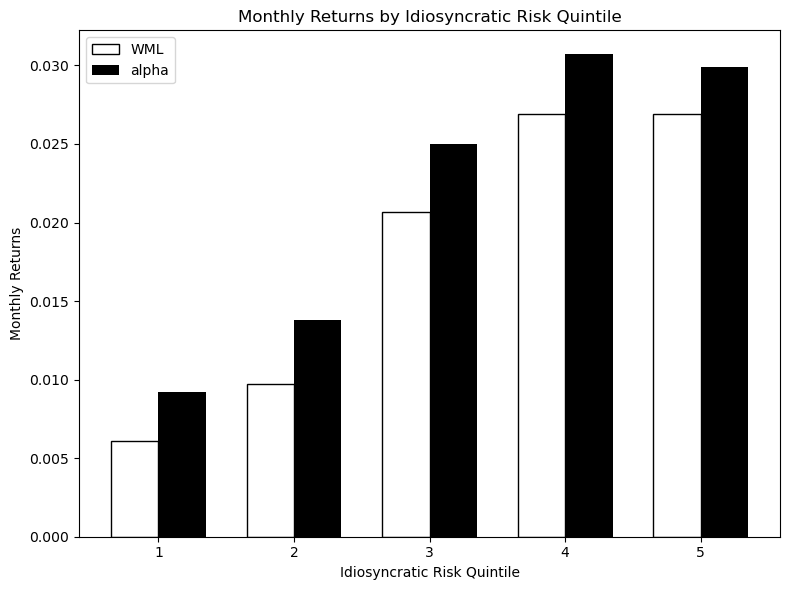

C:\Users\USER\AppData\Local\Temp\ipykernel_18604\997524124.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p_mkt_value = winner.groupby(['idio_risk_group','time'])['mkt_value'].transform('sum')
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\997524124.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winner[f'{variable}_wret'] = winner['RET']*p_weight
C:\Users\USER\AppData\Local\Temp\ipykernel_18604\997524124.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=Fal

reversal_group_winner 
 idio_risk_group       1       2       3       4       5
total_pret       0.0446  0.0469  0.0447  0.0487  0.0505

 reversal_group_loser 
 idio_risk_group       1       2       3       4      5
total_pret       0.0448  0.0462  0.0422  0.0384  0.024

 reversal_group_WML 
 idio_risk_group       1       2       3       4       5
WML             -0.0002  0.0007  0.0025  0.0103  0.0265 


 reversal_group_WML_pvalue 
 idio_risk_group       1       2       3       4    5
pvalue           0.0976  0.8443  0.4845  0.0066  0.0 


 reversal_group_WML_alpha 
 idio_risk_group       1       2      3       4       5
alpha            0.0012 -0.0056 -0.005  0.0023  0.0212 


 reversal_group_WML_alpha_pvalue 
 idio_risk_group       1       2       3       4    5
pvalue           0.8386  0.0658  0.1412  0.5143  0.0 



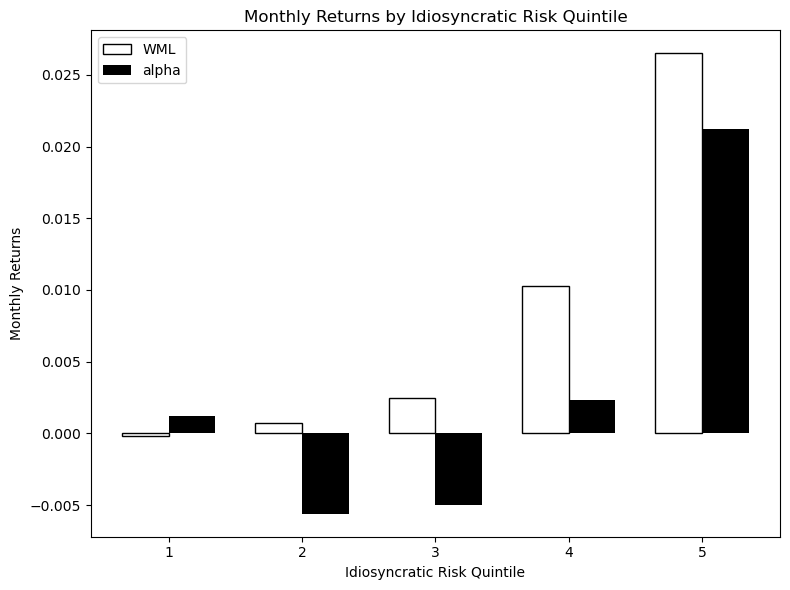

In [27]:
portfolio_df3 = portfolio_df.copy()
histogram_data = pd.DataFrame()
for variable in ['momentum_group', 'reversal_group'] :
    if variable == 'momentum_group' :
        winner = portfolio_df3[(portfolio_df3[variable]==5)]
        #winner_W = portfolio_df3[(portfolio_df3[variable]==5)&(portfolio_df3['idio_risk_group']==5)]
        #winner_L = portfolio_df3[(portfolio_df3[variable]==5)&(portfolio_df3['idio_risk_group']==1)]
        p_mkt_value = winner.groupby(['idio_risk_group','time'])['mkt_value'].transform('sum')
        p_weight = winner['mkt_value']/p_mkt_value
        winner[f'{variable}_wret'] = winner['RET']*p_weight
        winner[f'{variable}_ret'] = winner.groupby(['idio_risk_group','time'])[f'{variable}_wret'].transform('sum')
        for t in range(1,6) :
            winner[f'{variable}_wret{t}'] = winner[f'RET{t}']*p_weight
            winner[f'{variable}_ret{t}'] = winner.groupby(['idio_risk_group','time'])[f'{variable}_wret{t}'].transform('sum')
            winner[f'{variable}_ret{t}'] = winner.groupby(['idio_risk_group','time'])[f'{variable}_ret{t}'].shift(t)
        
        
        winner['total_pret'] = ( winner[f'{variable}_ret{1}']+ winner[f'{variable}_ret{2}'] + winner[f'{variable}_ret{3}'] + winner[f'{variable}_ret{4}'] + winner[f'{variable}_ret{5}'] + winner[f'{variable}_ret'])/6
        p = winner.drop_duplicates(['idio_risk_group', 'time', 'total_pret']).dropna(subset= ['total_pret'])
        W = p.groupby('idio_risk_group')['total_pret'].mean().round(4)
        
        loser = portfolio_df3[(portfolio_df3[variable]==1)]
        #loser_W = portfolio_df3[(portfolio_df3[variable]==1)&(portfolio_df3['idio_risk_group']==5)]
        #loser_L = portfolio_df3[(portfolio_df3[variable]==1)&(portfolio_df3['idio_risk_group']==1)]
        p_mkt_value = loser.groupby(['idio_risk_group','time'])['mkt_value'].transform('sum')
        p_weight = loser['mkt_value']/p_mkt_value
        loser[f'{variable}_wret'] = loser['RET']*p_weight
        loser[f'{variable}_ret'] = loser.groupby(['idio_risk_group','time'])[f'{variable}_wret'].transform('sum')
        for t in range(1,6) :
            loser[f'{variable}_wret{t}'] = loser[f'RET{t}']*p_weight
            loser[f'{variable}_ret{t}'] = loser.groupby(['idio_risk_group','time'])[f'{variable}_wret{t}'].transform('sum')
            loser[f'{variable}_ret{t}'] = loser.groupby(['idio_risk_group','time'])[f'{variable}_ret{t}'].shift(t)
        
        
        loser['total_pret'] = ( loser[f'{variable}_ret{1}']+ loser[f'{variable}_ret{2}'] + loser[f'{variable}_ret{3}'] + loser[f'{variable}_ret{4}'] + loser[f'{variable}_ret{5}'] + loser[f'{variable}_ret'])/6
        p1 = loser.drop_duplicates(['idio_risk_group', 'time', 'total_pret']).dropna(subset= ['total_pret'])
        L = p1.groupby('idio_risk_group')['total_pret'].mean().round(4)  
        
    else : 
        winner = portfolio_df3[(portfolio_df3[variable]==1)]
        #winner_W = portfolio_df3[(portfolio_df3[variable]==1)&(portfolio_df3['idio_risk_group']==5)]
        #winner_L = portfolio_df3[(portfolio_df3[variable]==1)&(portfolio_df3['idio_risk_group']==1)]
        p_mkt_value = winner.groupby(['idio_risk_group','time'])['mkt_value'].transform('sum')
        p_weight = winner['mkt_value']/p_mkt_value
        winner[f'{variable}_wret'] = winner['RET']*p_weight
        winner[f'{variable}_ret'] = winner.groupby(['idio_risk_group','time'])[f'{variable}_wret'].transform('sum')
        for t in range(1,6) :
            winner[f'{variable}_wret{t}'] = winner[f'RET{t}']*p_weight
            winner[f'{variable}_ret{t}'] = winner.groupby(['idio_risk_group','time'])[f'{variable}_wret{t}'].transform('sum')
            winner[f'{variable}_ret{t}'] = winner.groupby(['idio_risk_group','time'])[f'{variable}_ret{t}'].shift(t)
        
        
        winner['total_pret'] = ( winner[f'{variable}_ret{1}']+ winner[f'{variable}_ret{2}'] + winner[f'{variable}_ret{3}'] + winner[f'{variable}_ret{4}'] + winner[f'{variable}_ret{5}'] + winner[f'{variable}_ret'])/6
        p = winner.drop_duplicates(['idio_risk_group', 'time', 'total_pret']).dropna(subset= ['total_pret'])
        W = p.groupby('idio_risk_group')['total_pret'].mean().round(4)
        
        loser = portfolio_df3[(portfolio_df3[variable]==5)]
        #loser_W = portfolio_df3[(portfolio_df3[variable]==5)&(portfolio_df3['idio_risk_group']==5)]
        #loser_L = portfolio_df3[(portfolio_df3[variable]==5)&(portfolio_df3['idio_risk_group']==1)]
    #long_short = pd.merge(loser,winner,left_index=True, right_index=True)  
        p_mkt_value = loser.groupby(['idio_risk_group','time'])['mkt_value'].transform('sum')
        p_weight = loser['mkt_value']/p_mkt_value
        loser[f'{variable}_wret'] = loser['RET']*p_weight
        loser[f'{variable}_ret'] = loser.groupby(['idio_risk_group','time'])[f'{variable}_wret'].transform('sum')
        for t in range(1,6) :
            loser[f'{variable}_wret{t}'] = loser[f'RET{t}']*p_weight
            loser[f'{variable}_ret{t}'] = loser.groupby(['idio_risk_group','time'])[f'{variable}_wret{t}'].transform('sum')
            loser[f'{variable}_ret{t}'] = loser.groupby(['idio_risk_group','time'])[f'{variable}_ret{t}'].shift(t)
        
        
        loser['total_pret'] = ( loser[f'{variable}_ret{1}']+ loser[f'{variable}_ret{2}'] + loser[f'{variable}_ret{3}'] + loser[f'{variable}_ret{4}'] + loser[f'{variable}_ret{5}'] + loser[f'{variable}_ret'])/6
        p1 = loser.drop_duplicates(['idio_risk_group', 'time', 'total_pret']).dropna(subset= ['total_pret'])
        L = p1.groupby('idio_risk_group')['total_pret'].mean().round(4) 
    
    W_minus_L = W-L    
    W_minus_L = pd.DataFrame(W_minus_L)
    W_minus_L = W_minus_L.rename(columns= {W_minus_L.columns[0] : 'WML'})
    #W = pd.DataFrame(winner.groupby('idio_risk_group')['total_pret'].mean())
    #L = pd.DataFrame(loser.groupby('idio_risk_group')['total_pret'].mean())
    win = p[['time', 'total_pret','sprtrn', 'Mkt-RF', 'HML', 'SMB','idio_risk_group']].reset_index(drop= True).set_index(['time','idio_risk_group']).rename(columns={'total_pret' : 'winner'})
    lose = p1[['time', 'total_pret','idio_risk_group']].reset_index(drop= True).set_index(['time','idio_risk_group']).rename(columns={'total_pret' : 'loser'})
    if len(lose) > len(win) : 
        long_short = pd.merge(lose,win,left_index=True, right_index=True,how= 'right')
    else :
        long_short = pd.merge(lose,win,left_index=True, right_index=True,how= 'left')
    
    
    long_short['WML'] = long_short['winner'] - long_short['loser']
    # 假設檢定的母體平均值為 2.5
    population_mean = 0
    #mean = long_short.groupby(level= 1)['WML'].mean().round(3)
    test = long_short.groupby(level= 1)['WML'].apply(lambda x : ttest_1samp(x, popmean = population_mean, nan_policy='omit').pvalue.round(4))
    test = pd.DataFrame(test)
    test = test.rename(columns= {test.columns[0] : 'pvalue'})
    #Y = long_short['WML']
    
   

    # 提取截距項 (alpha)
    alpha = long_short.groupby(level= 1).apply(lambda x : sm.OLS(x['WML'], sm.add_constant(x[['Mkt-RF', 'HML', 'SMB']].astype('float')), missing= 'drop').fit().params[0].round(4))
    alpha = pd.DataFrame(alpha)
    alpha = alpha.rename(columns= {alpha.columns[0] : 'alpha'})
    alpha_pvalue = long_short.groupby(level= 1).apply(lambda x : sm.OLS(x['WML'], sm.add_constant(x[['Mkt-RF', 'HML', 'SMB']].astype('float')), missing= 'drop').fit().pvalues[0].round(4))
    alpha_pvalue = pd.DataFrame(alpha_pvalue)
    alpha_pvalue = alpha_pvalue.rename(columns= {alpha_pvalue.columns[0] : 'pvalue'})
    
    mean_n_alpha = pd.merge(W_minus_L, alpha, right_index=True, left_index=True )
    
    
    print(f'{variable}_winner','\n',pd.DataFrame(W).T)
    print('\n',f'{variable}_loser','\n',pd.DataFrame(L).T)
    print('\n',f'{variable}_WML','\n',W_minus_L.T,'\n')
    print('\n',f'{variable}_WML_pvalue','\n',test.T,'\n')
    print('\n',f'{variable}_WML_alpha','\n',alpha.T,'\n')
    print('\n',f'{variable}_WML_alpha_pvalue','\n',alpha_pvalue.T,'\n')
    
    histogram_plot(mean_n_alpha, 'WML', 'alpha')
        
